In [30]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
img = cv2.imread("./data/faces93")


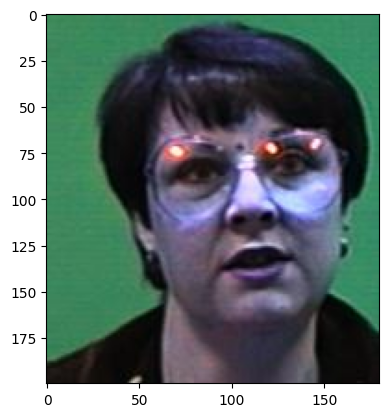

In [11]:
femal_path = "./data/faces94/female/9336923/"
for file in os.listdir(femal_path):
    file_path = os.path.join(femal_path, file)
    image = cv2.imread(file_path)
    plt.imshow(image)
    

In [32]:
from tqdm import tqdm

image_data = []
photos_path= "./data/faces94"
for folder in os.listdir(photos_path):
    print("going through folders")
    inside_folder_path = os.path.join(photos_path, folder)
    for images_folder in tqdm(os.listdir(inside_folder_path)):
        images_folder_path = os.path.join(inside_folder_path, images_folder)
        for image_file in filter(lambda x: x.endswith("jpg"), os.listdir(images_folder_path)):
            image_file_path = os.path.join(images_folder_path, image_file)
            image = cv2.imread(image_file_path)
            image_data.append({'Filename': image_file_path, 'ImageArray': image})

print("Created the dataframe")

going through folders


100%|██████████| 20/20 [00:00<00:00, 42.17it/s]


going through folders


100%|██████████| 113/113 [00:03<00:00, 35.54it/s]


going through folders


100%|██████████| 20/20 [00:00<00:00, 30.16it/s]

Creating the dataframe


In [46]:
images = list(map(lambda item: item["ImageArray"], image_data))
files_path = list(map(lambda item: item["Filename"], image_data))
images = np.array(images)

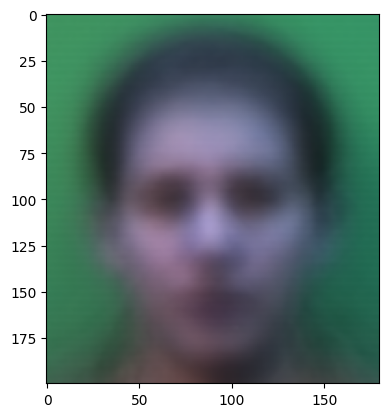

In [67]:
average_image = images.mean(axis=0)
average_image = np.round(average_image)
average_image = average_image.astype(np.uint8)
plt.imshow(average_image)

In [86]:
images_vectors = (images - average_image).reshape(images.shape[0], -1) # Normalizing images
images_vectors = images_vectors.T

In [87]:

# Compute the covariance matrix of the vectors
cov_matrix = np.cov(images_vectors)

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

MemoryError: Unable to allocate 86.9 GiB for an array with shape (108000, 108000) and data type float64

In [ ]:
# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]